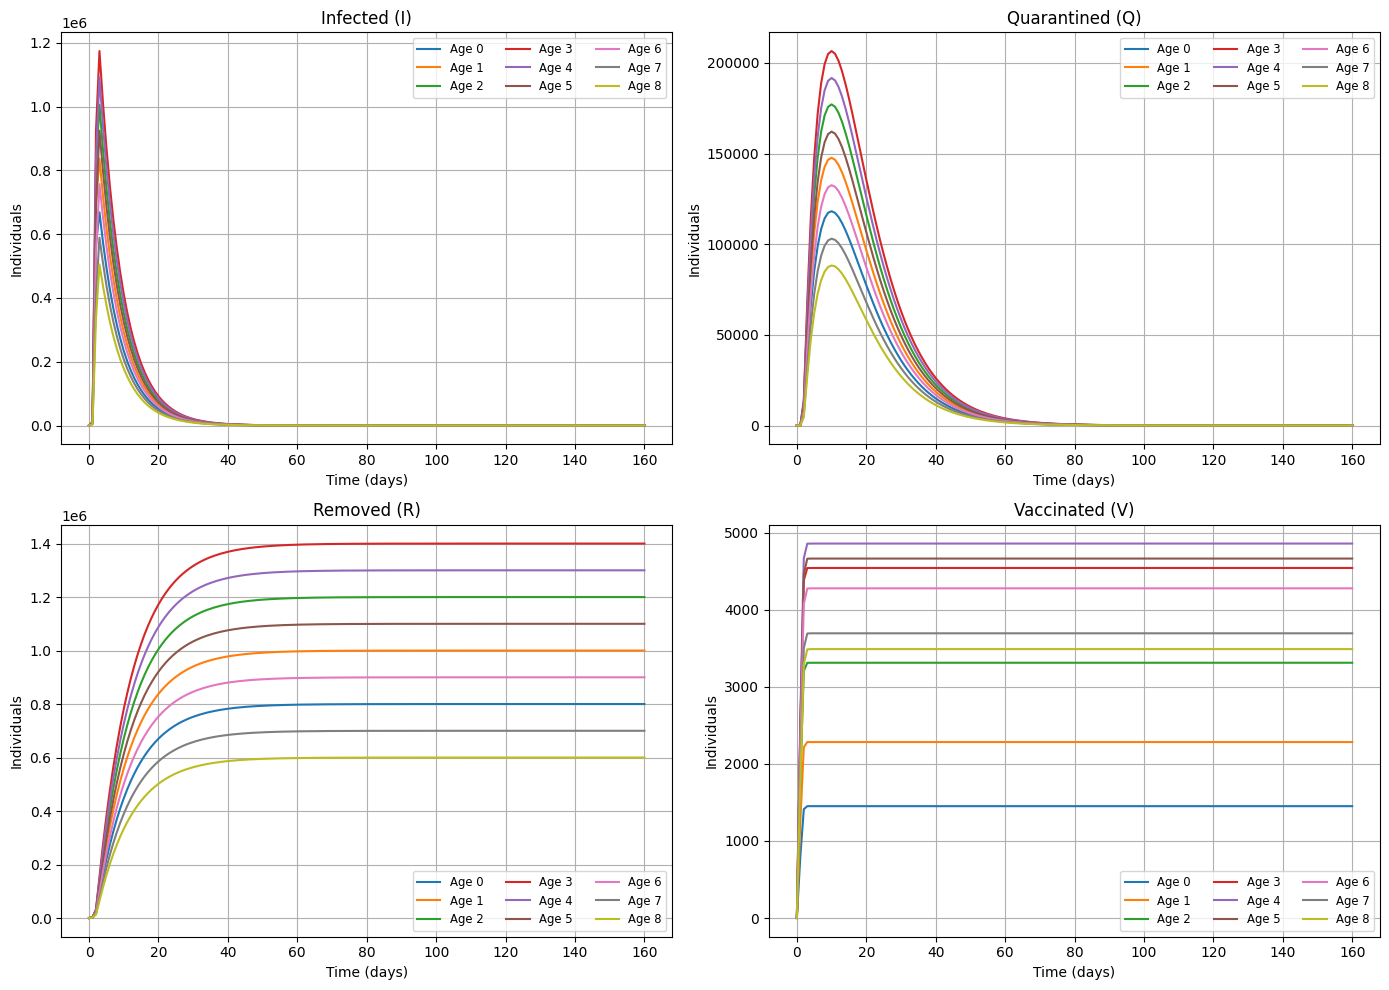

In [4]:
import os, pathlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp  # ← add this line

# Redefine the model with 9 age groups 
n_age = 9

# Fake population sizes for 9 groups (e.g., increasing with age group)
N_i = np.array([0.8e6, 1.0e6, 1.2e6, 1.4e6, 1.3e6, 1.1e6, 0.9e6, 0.7e6, 0.6e6])
beta_i = np.linspace(0.20, 0.14, n_age)           # decreasing transmission rate with age
gamma_i = np.full(n_age, 0.1)                     # uniform recovery rate
q_i = np.full(n_age, 0.05)                        # uniform quarantine rate
u_i = np.linspace(0.001, 0.003, n_age)            # increasing vaccination rate with age

# Contact matrix (for demonstration, symmetric and structured)
M = np.ones((n_age, n_age)) * 3
np.fill_diagonal(M, 10)

# Initial conditions
S0 = N_i - 100
I0 = np.random.randint(10, 50, size=n_age)
Q0 = np.zeros(n_age)
R0 = np.zeros(n_age)
V0 = np.zeros(n_age)
y0 = np.concatenate([S0, I0, Q0, R0, V0])

# Redefine the time axis
t_eval = np.linspace(0, 160, 161)

# Updated ODE system for 9 age groups
def model_age9(t, y):
    dydt = np.zeros_like(y)
    S = y[0:n_age]
    I = y[n_age:2*n_age]
    Q = y[2*n_age:3*n_age]
    R = y[3*n_age:4*n_age]
    V = y[4*n_age:5*n_age]

    for i in range(n_age):
        force = sum(M[i, j] * I[j] / N_i[j] for j in range(n_age))
        dS = -beta_i[i] * S[i] * force - u_i[i] * S[i]
        dI = beta_i[i] * S[i] * force - gamma_i[i] * I[i] - q_i[i] * I[i]
        dQ = q_i[i] * I[i] - gamma_i[i] * Q[i]
        dR = gamma_i[i] * (I[i] + Q[i]) + u_i[i] * S[i]
        dV = u_i[i] * S[i]

        dydt[i] = dS
        dydt[i+n_age] = dI
        dydt[i+2*n_age] = dQ
        dydt[i+3*n_age] = dR
        dydt[i+4*n_age] = dV
    return dydt

# Solve ODEs
sol9 = solve_ivp(model_age9, [t_eval[0], t_eval[-1]], y0, t_eval=t_eval)

# Plot: aggregate infected (I), quarantined (Q), removed (R), and vaccinated (V)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
compartments = ['Infected (I)', 'Quarantined (Q)', 'Removed (R)', 'Vaccinated (V)']
indices = [n_age, 2*n_age, 3*n_age, 4*n_age]

for ax, label, idx in zip(axs.flat, compartments, indices):
    for i in range(n_age):
        ax.plot(t_eval, sol9.y[i + idx], label=f'Age {i}')
    ax.set_title(label)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Individuals')
    ax.grid(True)
    ax.legend(ncol=3, fontsize='small')

plt.tight_layout()
plt.show()